In [ ]:
# CNN은 이미지 인식에 탁월한 효과를 보이는 딥러닝 신경망이다. 그러나 문서 분류에서 뛰어난 효과를 보이는 것으로 입증되었다.
# CNN에서 주변 정보들을 요약하고 특성을 추출하는 과정은 두 단계로 이루어져 있다.
# 첫 단계는 원본 이미지에 필터를 적용해 주변 정보를 요약하는 '컨볼루션 단계'다. 필터는 원본 이미지보다 작은 2차원 행렬로 학습의 대상이
# 되는 파라미터인데, 보통 3x3, 5x5의 크기를 많이 사용한다.
# 컨볼루션에서 중요한 요소는 필터 혹은 채널의 수다. 이미지를 판별하려면 다양한 관점에서 이미지를 분석할 필요가 있다.
# 이를 반영하기 위해 필터의 수를 여러 개로 할 수 있다. 하나의 이미지로부터 두 개의 서로 다른 요약정보를 추출하는 것이다.
# 두번째 단계는 풀링으로, 요약된 2차원 행렬을 축소하는 단계이다.

In [1]:
# CNN을 이용한 문서 분류
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# movie review data에서 fild id를 가져옴
fileids = movie_reviews.fileids()
# file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 # 사용할 단어의 수
maxlen = 500 # 문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words = max_words, oov_token = 'UNK')
tokenizer.fit_on_texts(reviews) # 단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews) # 만들어진 단어 인덱스를 이용해 변환
X = pad_sequences(X, maxlen = maxlen, truncating='pre')

# label을 0,1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([label_dict[c] for c in categories])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # word embedding layer 생성
    Embedding(max_words, 64, input_length = maxlen),
    Conv1D(128, #채널의 수
          5, # 1D 필터의 크기
          padding='valid',
          activation='relu',
          strides=1),
    MaxPooling1D(),
    Conv1D(256, # 채널의 수
          5, # 1D 필터의 크기
          padding='valid',
          activation='relu',
          strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') # binary logistic regression을 수행
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1  (None, 248, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 122, 256)          0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 31232)             0

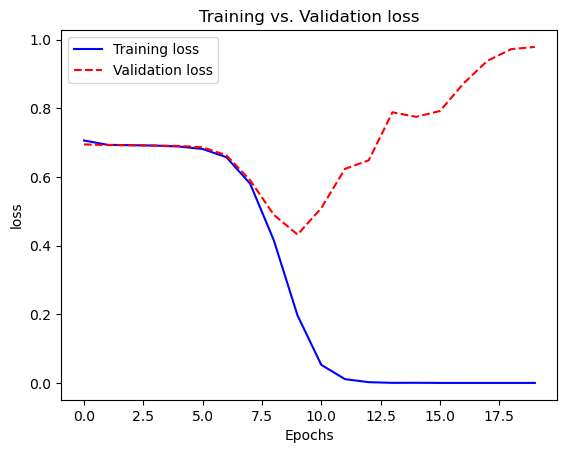

13/13 [==============================] - 0s 23ms/step - loss: 1.0097 - acc: 0.8150
#Test accuracy:0.815


In [3]:
# 테스트 데이터에 대한 정확도를 보면, RNN모형에 비해 우수한 81.5%가 나온 것을 볼 수 있다.
# 이 한 번의 결과로 단정할 수는 없으나, 적어도 RNN 못지않은 성능을 보인다고 생각할 수 있다.

adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size=256,
                   verbose=0,
                   validation_split=0.2)
# 학습 결과 그래프를 그린다.
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
plot_results(history, 'loss')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')